### Comparacion comunidades del algoritmo de Louvain con base de relaciones societarias y contador con data de grupos economicos reales

In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
import pyspark
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
from pyspark.sql.types import StringType,TimestampType
from sklearn.metrics import adjusted_mutual_info_score

### Inicio de sesion en Spark

In [16]:
spark = SparkSession.builder \
  .appName("Test")  \
  .config("spark.yarn.access.hadoopFileSystems","abfs://data@datalakesii.dfs.core.windows.net/") \
  .config("spark.executor.memory", "24g") \
  .config("spark.driver.memory", "12g")\
  .config("spark.executor.cores", "12") \
  .config("spark.executor.instances", "24") \
  .config("spark.driver.maxResultSize", "12g") \
  .getOrCreate()

warnings.filterwarnings('ignore', category=DeprecationWarning)
sc=spark.sparkContext
sc.setLogLevel ('ERROR')
spark.conf.set("spark.sql.parquet.int96RebaseModeInRead", "CORRECTED")


En primer lugar, leemos la data de los grupos conocidos y quitamos los datos duplicados.

In [17]:
data_test=spark.read.parquet("abfs://data@datalakesii.dfs.core.windows.net/DatosOrigen/LibSDF/GE_APIUX_ARFI_E").createOrReplaceTempView("grupos_conocidos")

In [18]:
spark.sql('select PARU_RUT_E, COM, count(*) as c from grupos_conocidos  group by PARU_RUT_E, COM order by PARU_RUT_E asc').createOrReplaceTempView("grupos_conocidos")
spark.sql('select *  from  grupos_conocidos').show()
spark.sql('select PARU_RUT_E, COM from  grupos_conocidos').createOrReplaceTempView("grupos_conocidos")


+--------------------+----+---+
|          PARU_RUT_E| COM|  c|
+--------------------+----+---+
|+++4/3jzUwtDPSSo3...| 460|  1|
|++7yFnLR2jk0Wr0e8...|2478|  1|
|++WLg1DbuZQ0MUQEN...|2915|  2|
|++YxswwB51l+3P6mO...|1799|  2|
|++ggVpHHILx+9SGu8...|1141|  1|
|++qoXOhoawzvRog9E...| 999|  1|
|+/+yqr5XeK0rOoKkG...|3114|  1|
|+/HrCRshGy4wSSO1V...| 126|  1|
|+/JZf0TTOGVxNx9tj...| 325|  1|
|+/R7TO3QchPVrRHn9...|1091|  1|
|+/bsZuw7/ADsTou53...|2202|  1|
|+/cJ7EBd5oKjQfhxu...|1018|  2|
|+0dURcPCBYLGVKmIt...| 614|  1|
|+0f/GM34xojh+tn7A...| 321|  1|
|+0ut+stCHqH6UHSAh...|2659|  1|
|+0yKx5GSw/Q5FoSrp...|1157|  3|
|+1FNxAxXZVPFSdmBl...|1920|  1|
|+1YKE5LQO+CE2nB6H...| 595|  1|
|+1eDEaPXcR4UTQlQz...|1329|  1|
|+1iuDsJuEu9oPjZFA...| 330|  1|
+--------------------+----+---+
only showing top 20 rows



In [19]:
spark.sql('select count(*) from  grupos_conocidos').show()

+--------+
|count(1)|
+--------+
|   18475|
+--------+



Esta es una query para poder filtrar los grupos conocidos cuando queramos un minimo de miembros en cada grupo conocido.

### Lectura de datos de particion de Louvain para diferentes resoluciones

In [20]:
grupos_malla = spark.read.options(header=True,inferSchema=True,delimiter=",").csv("/home/cdsw/data/processed/louvain_malla_societaria_contador/louvain_malla_societaria_contador.csv")

Cambiamos los nombres de las columnas para no tener poblemas de lectura

In [21]:
grupos_malla = grupos_malla.withColumnRenamed("comunidad_0.0", "comunidad_00") \
                           .withColumnRenamed("comunidad_0.1", "comunidad_01") \
                           .withColumnRenamed("comunidad_0.2", "comunidad_02") \
                           .withColumnRenamed("comunidad_0.3", "comunidad_03") \
                           .withColumnRenamed("comunidad_0.4", "comunidad_04") \
                           .withColumnRenamed("comunidad_0.5", "comunidad_05") \
                           .withColumnRenamed("comunidad_0.6", "comunidad_06") \
                           .withColumnRenamed("comunidad_0.7", "comunidad_07") \
                           .withColumnRenamed("comunidad_0.8", "comunidad_08") \
                           .withColumnRenamed("comunidad_0.9", "comunidad_09") \
                           .withColumnRenamed("comunidad_1.0", "comunidad_10")

grupos_malla.createOrReplaceTempView("grupos_malla")


### Adjusted mutual info score para comunidades de Louvain y comunidades reales

El adjusted_mutual_info_score (AMI) es una métrica utilizada para evaluar la similitud entre dos agrupaciones o particiones de datos. Es una medida de cuánta información comparten dos agrupaciones, ajustada para tener en cuenta la probabilidad de que las agrupaciones coincidan al azar.

El AMI se calcula utilizando la información mutua ajustada, que es una medida de cuánta información compartida hay entre dos agrupaciones, normalizada por la entropía de las agrupaciones individuales.

El AMI devuelve un valor en el rango [0, 1]. Un valor de 1 indica una perfecta similitud entre las agrupaciones, mientras que un valor cercano a 0 indica que las agrupaciones son independientes. Un valor negativo indica que las agrupaciones son diferentes en comparación con lo que se esperaría al azar. Ahora este indice sera obtenido para cada resolucion de la particion de Louvain. 

In [22]:
df=spark.sql('select PARU_RUT_E,COM, TIPO, comunidad_00,comunidad_01,comunidad_02,comunidad_03,comunidad_04,comunidad_05,comunidad_06,comunidad_07,comunidad_08,comunidad_09,comunidad_10 from  grupos_conocidos left join grupos_malla on grupos_conocidos.PARU_RUT_E=grupos_malla.RUT_UNICO where grupos_malla.RUT_UNICO is not null').toPandas()
len(df)

17910

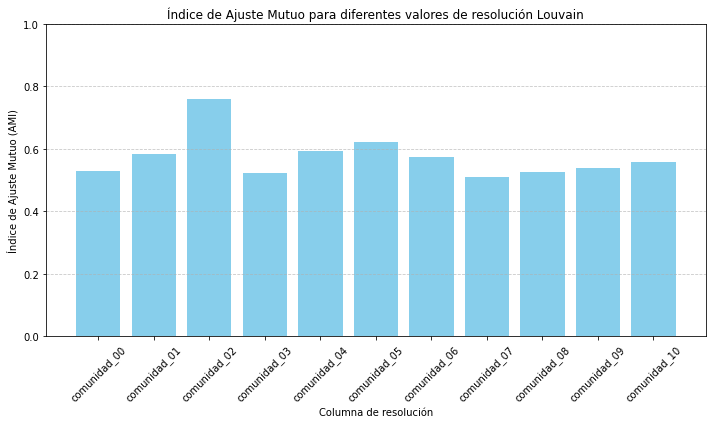

[0.527617778253166, 0.5821019920267102, 0.7588234744092187, 0.5236061679324955, 0.5917100814588795, 0.6206718299705218, 0.5730681412866778, 0.5092816466022676, 0.524451528871248, 0.5390109343931822, 0.5592058744360141]


In [23]:
# Extraer las columnas de resolución y las asignaciones reales
columnas_resolucion = ['comunidad_00', 'comunidad_01', 'comunidad_02', 'comunidad_03', 'comunidad_04',
                       'comunidad_05', 'comunidad_06', 'comunidad_07', 'comunidad_08', 'comunidad_09', 'comunidad_10']
asignacion_real = df['COM']

# Calcular el Índice de Ajuste Mutuo para cada columna de resolución
ami_scores = []
for columna in columnas_resolucion:
    asignacion_predicha = df[columna]
    ami = adjusted_mutual_info_score(asignacion_real, asignacion_predicha)
    ami_scores.append(ami)

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.bar(columnas_resolucion, ami_scores, color='skyblue')
plt.xlabel('Columna de resolución')
plt.ylabel('Índice de Ajuste Mutuo (AMI)')
plt.title('Índice de Ajuste Mutuo para diferentes valores de resolución Louvain')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [32]:
import numpy as np
promedio_ami = np.mean(ami_scores)
maximo_ami = np.max(ami_scores)
print(promedio_ami)
print(maximo_ami)

0.5735954045127619
0.7588234744092187


In [24]:
df=pd.read_csv('/home/cdsw/data/processed/louvain_malla_societaria_contador/resolucion_modularidad.csv')

Un valor de Adjusted Mutual Information (AMI) inferior a 0.2 indica una asociación muy débil o insignificante entre las particiones obtenidas por el algoritmo Louvain en diferentes resoluciones. El Adjusted Mutual Information mide la similitud entre dos agrupaciones, teniendo en cuenta la posibilidad de asociaciones aleatorias. Por lo tanto, un valor bajo de AMI sugiere que las agrupaciones no están relacionadas de manera significativa o que hay muy poca coincidencia entre ellas.